In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load results
with open('../results/information_flow_full_2025-11-17-12-42-41-3911.json', 'r') as f:
    data = json.load(f)

print(f"Examples: {data['num_examples']}")
print(f"Layers: {data['num_layers']}")
print(f"Steps: {len(data['results'])}")


Examples: 400
Layers: 32
Steps: 6


In [2]:
# Extract data for plotting
results = data['results']
num_layers = data['num_layers']
steps = sorted(results.keys(), key=lambda x: int(x.split('_')[1]))

# Get chunk names
sample_step = results[steps[0]]
sample_layer = list(sample_step.keys())[0]
all_chunks = list(sample_step[sample_layer].keys())
print(f"Chunks: {all_chunks}")


Chunks: ['init_state', 'goal_state', 'history_1', 'history_2', 'history_3', 'history_4', 'history_5', 'history_6']


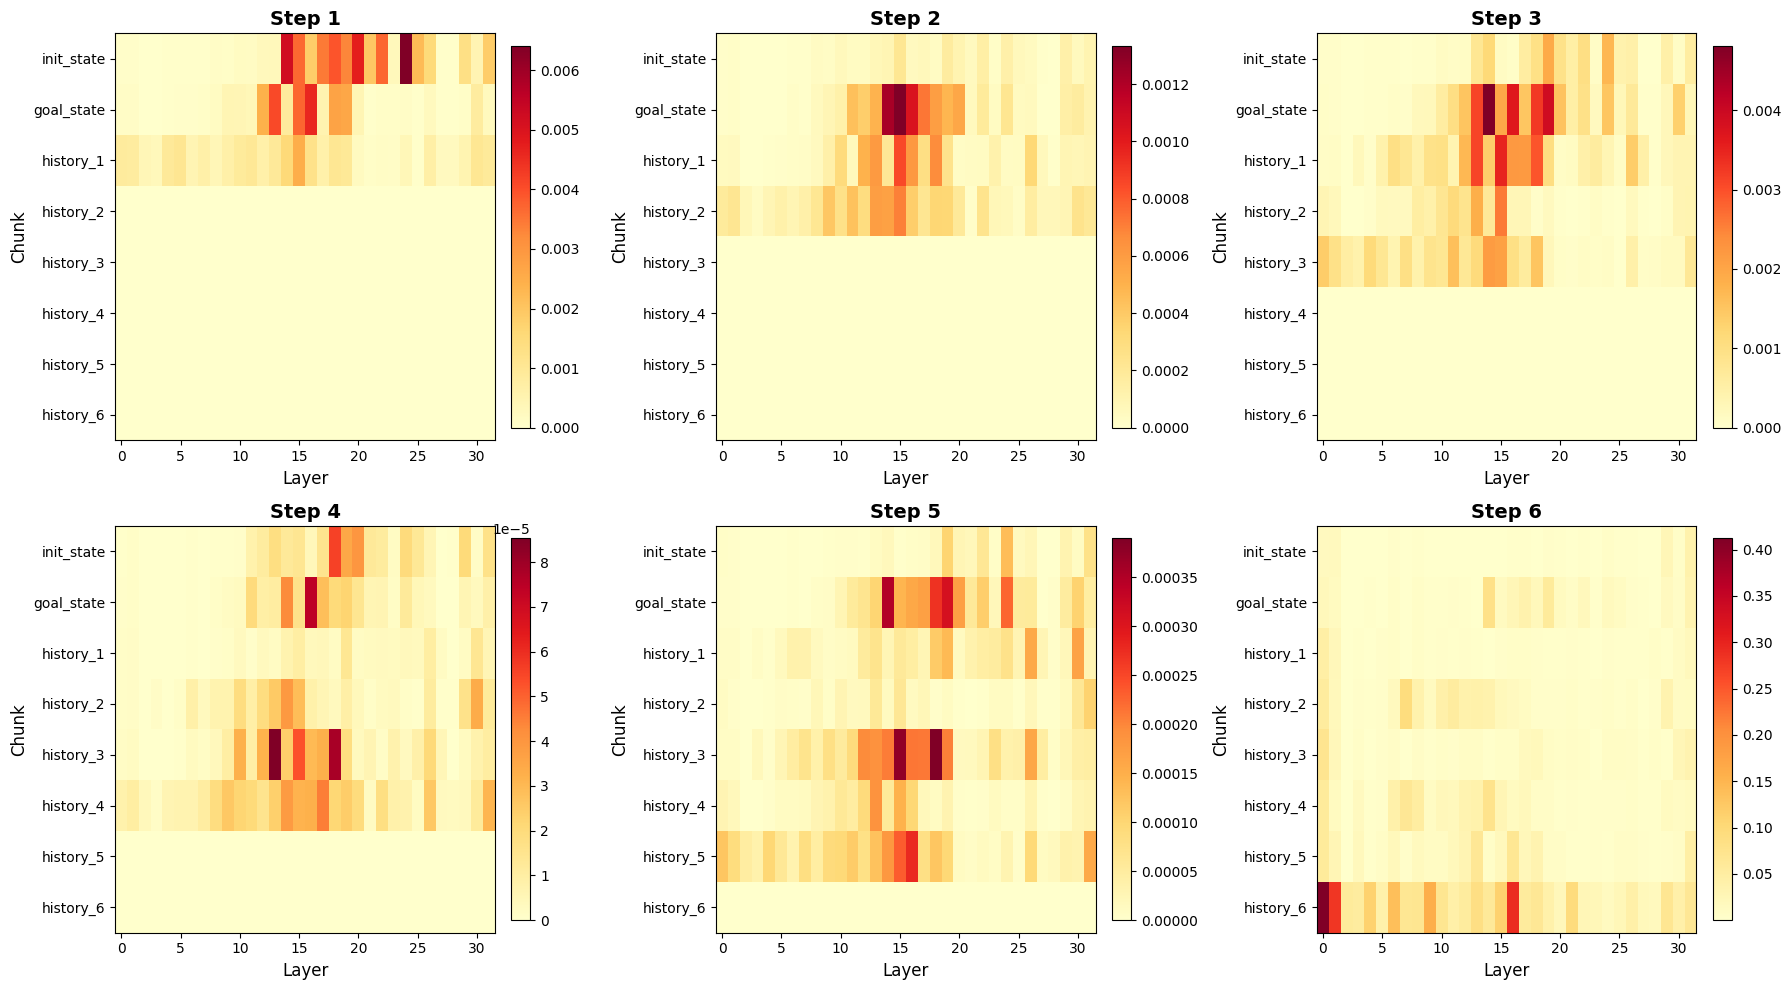


Heatmaps saved to results/information_flow_heatmaps_full.png


In [3]:
# Create heatmap for each step (Figure 5 style from paper)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

meaningful_chunks = ['init_state', 'goal_state', 'history_1', 'history_2', 'history_3', 'history_4', 'history_5', 'history_6']

for step_idx, step_key in enumerate(steps):
    ax = axes[step_idx]
    
    # Build matrix: [chunks x layers]
    matrix = []
    for chunk_name in meaningful_chunks:
        row = []
        for layer_idx in range(num_layers):
            layer_key = str(layer_idx)
            if layer_key in results[step_key] and chunk_name in results[step_key][layer_key]:
                row.append(results[step_key][layer_key][chunk_name])
            else:
                row.append(0.0)
        matrix.append(row)
    
    # Plot heatmap
    im = ax.imshow(matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    ax.set_title(f'{step_key.replace("_", " ").title()}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Layer', fontsize=12)
    ax.set_ylabel('Chunk', fontsize=12)
    ax.set_yticks(range(len(meaningful_chunks)))
    ax.set_yticklabels(meaningful_chunks, fontsize=10)
    ax.set_xticks(range(0, num_layers, 5))
    ax.set_xticklabels(range(0, num_layers, 5))
    
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('../results/information_flow_heatmaps_full.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nHeatmaps saved to results/information_flow_heatmaps_full.png")


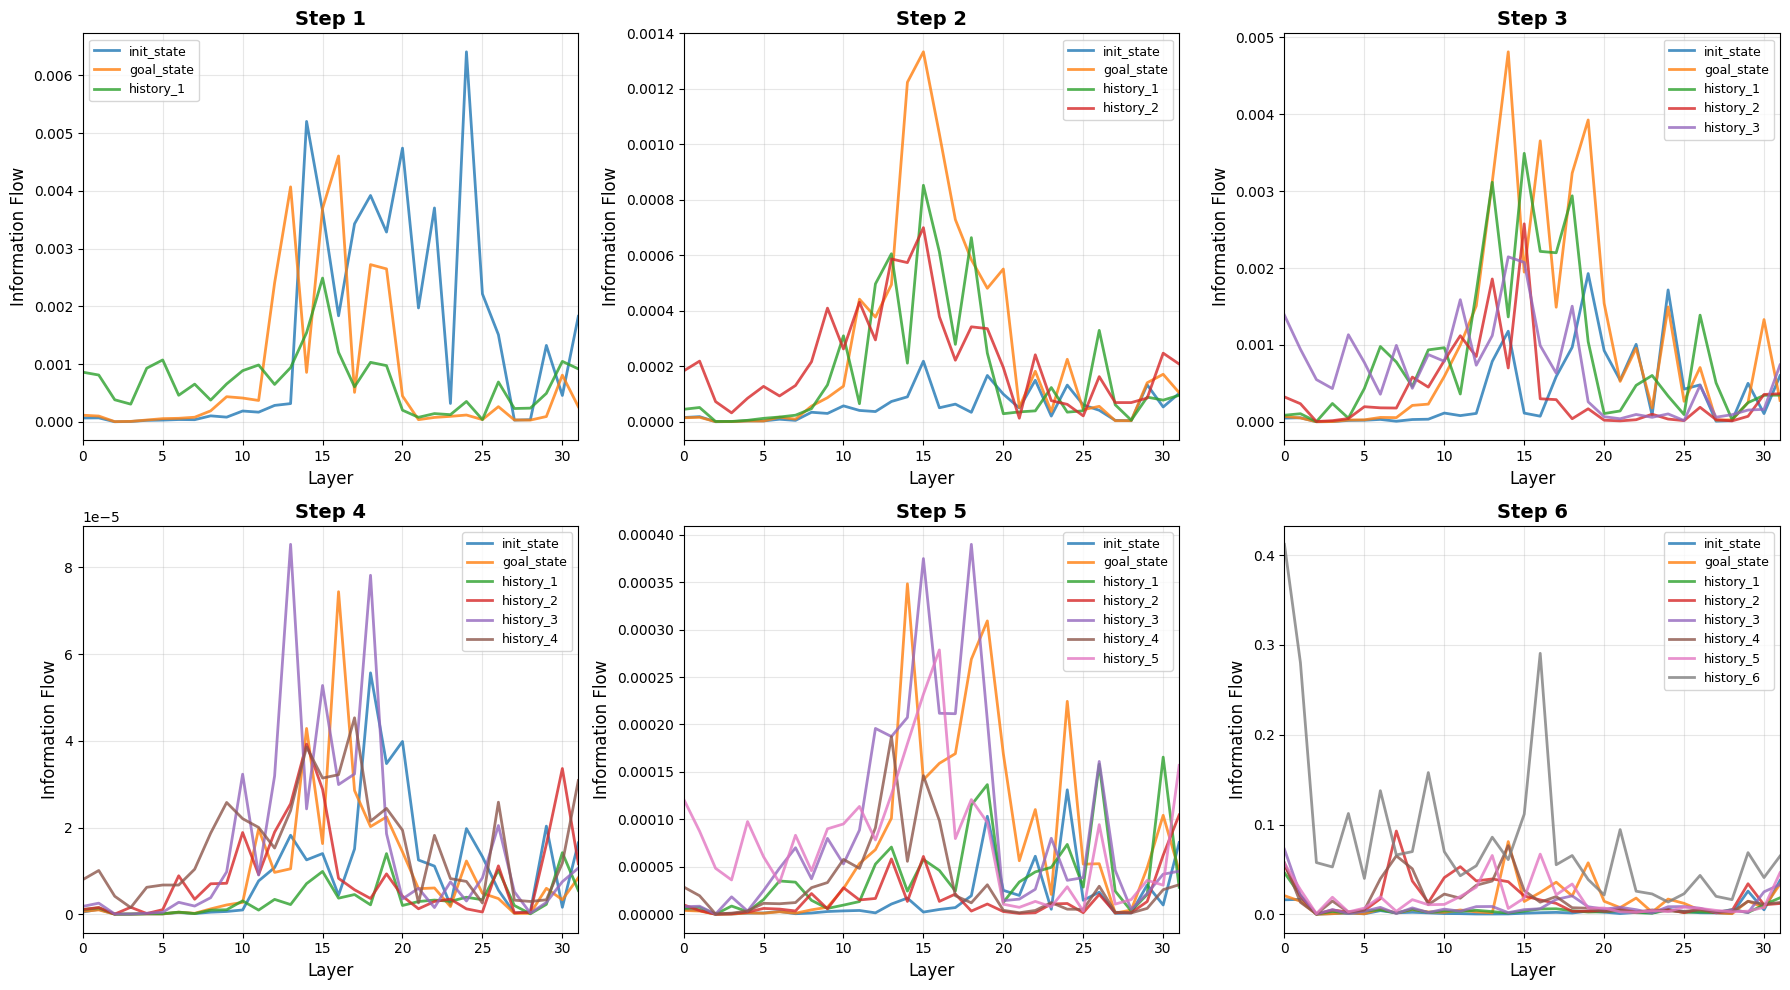


Line plots saved to results/information_flow_lines_full.png


In [4]:
# Plot flow across layers for key chunks (goal_state vs recent history)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

colors = {
    'init_state': '#1f77b4',
    'goal_state': '#ff7f0e',
    'history_1': '#2ca02c',
    'history_2': '#d62728',
    'history_3': '#9467bd',
    'history_4': '#8c564b',
    'history_5': '#e377c2',
    'history_6': '#7f7f7f',
}

for step_idx, step_key in enumerate(steps):
    ax = axes[step_idx]
    step_num = int(step_key.split('_')[1])
    
    # Plot relevant chunks (up to current step)
    chunks_to_plot = ['init_state', 'goal_state'] + [f'history_{i}' for i in range(1, step_num + 1)]
    
    for chunk_name in chunks_to_plot:
        flows = []
        for layer_idx in range(num_layers):
            layer_key = str(layer_idx)
            if layer_key in results[step_key] and chunk_name in results[step_key][layer_key]:
                flows.append(results[step_key][layer_key][chunk_name])
            else:
                flows.append(0.0)
        
        ax.plot(range(num_layers), flows, label=chunk_name, color=colors[chunk_name], linewidth=2, alpha=0.8)
    
    ax.set_title(f'{step_key.replace("_", " ").title()}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Layer', fontsize=12)
    ax.set_ylabel('Information Flow', fontsize=12)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, num_layers - 1)

plt.tight_layout()
plt.savefig('../results/information_flow_lines_full.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLine plots saved to results/information_flow_lines_full.png")


In [5]:
# Analyze key observations
print("\n" + "="*60)
print("KEY OBSERVATIONS")
print("="*60)

for step_key in steps:
    step_num = int(step_key.split('_')[1])
    print(f"\n{step_key.replace('_', ' ').title()}:")
    
    # Find layer with max goal_state flow
    max_goal_flow = 0
    max_goal_layer = 0
    for layer_idx in range(num_layers):
        layer_key = str(layer_idx)
        if layer_key in results[step_key] and 'goal_state' in results[step_key][layer_key]:
            flow = results[step_key][layer_key]['goal_state']
            if flow > max_goal_flow:
                max_goal_flow = flow
                max_goal_layer = layer_idx
    
    print(f"  - Peak goal_state flow: {max_goal_flow:.4f} at layer {max_goal_layer}")
    
    # Compare goal_state vs recent history at layer 16
    layer_16 = results[step_key].get('16', {})
    goal_flow = layer_16.get('goal_state', 0)
    if step_num > 1:
        prev_history = layer_16.get(f'history_{step_num-1}', 0)
        print(f"  - At layer 16: goal_state={goal_flow:.4f}, history_{step_num-1}={prev_history:.4f}")
        if goal_flow > prev_history:
            print(f"    → Model looks more at GOAL than recent history")
        else:
            print(f"    → Model looks more at RECENT HISTORY than goal")



KEY OBSERVATIONS

Step 1:
  - Peak goal_state flow: 0.0046 at layer 16

Step 2:
  - Peak goal_state flow: 0.0013 at layer 15
  - At layer 16: goal_state=0.0010, history_1=0.0006
    → Model looks more at GOAL than recent history

Step 3:
  - Peak goal_state flow: 0.0048 at layer 14
  - At layer 16: goal_state=0.0037, history_2=0.0003
    → Model looks more at GOAL than recent history

Step 4:
  - Peak goal_state flow: 0.0001 at layer 16
  - At layer 16: goal_state=0.0001, history_3=0.0000
    → Model looks more at GOAL than recent history

Step 5:
  - Peak goal_state flow: 0.0003 at layer 14
  - At layer 16: goal_state=0.0002, history_4=0.0001
    → Model looks more at GOAL than recent history

Step 6:
  - Peak goal_state flow: 0.0810 at layer 14
  - At layer 16: goal_state=0.0243, history_5=0.0671
    → Model looks more at RECENT HISTORY than goal


In [6]:
# Summary statistics
print("\n" + "="*60)
print("SUMMARY: Goal State vs History")
print("="*60)

for step_key in steps:
    step_num = int(step_key.split('_')[1])
    
    # Average across all layers
    goal_flows = []
    history_flows = []
    
    for layer_idx in range(num_layers):
        layer_key = str(layer_idx)
        if layer_key in results[step_key]:
            goal_flows.append(results[step_key][layer_key].get('goal_state', 0))
            
            # Sum all visible history chunks
            total_history = sum(
                results[step_key][layer_key].get(f'history_{i}', 0)
                for i in range(1, step_num + 1)
            )
            history_flows.append(total_history)
    
    avg_goal = np.mean(goal_flows)
    avg_history = np.mean(history_flows)
    
    print(f"\n{step_key.replace('_', ' ').title()}:")
    print(f"  Avg goal_state flow: {avg_goal:.4f}")
    print(f"  Avg total history flow: {avg_history:.4f}")
    print(f"  Ratio (goal/history): {avg_goal/avg_history if avg_history > 0 else float('inf'):.2f}")



SUMMARY: Goal State vs History

Step 1:
  Avg goal_state flow: 0.0008
  Avg total history flow: 0.0007
  Ratio (goal/history): 1.15

Step 2:
  Avg goal_state flow: 0.0003
  Avg total history flow: 0.0004
  Ratio (goal/history): 0.67

Step 3:
  Avg goal_state flow: 0.0010
  Avg total history flow: 0.0019
  Ratio (goal/history): 0.54

Step 4:
  Avg goal_state flow: 0.0000
  Avg total history flow: 0.0000
  Ratio (goal/history): 0.23

Step 5:
  Avg goal_state flow: 0.0001
  Avg total history flow: 0.0003
  Ratio (goal/history): 0.31

Step 6:
  Avg goal_state flow: 0.0135
  Avg total history flow: 0.1549
  Ratio (goal/history): 0.09
